<a href="https://colab.research.google.com/github/aseelalzaben03/TASK2-/blob/main/Task_2_Pretrained_model_Teeth_Classification_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils import class_weight
import numpy as np


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = '/content/drive/My Drive/Teeth_Dataset'

In [5]:
import os
dataset_path = '/content/drive/My Drive/Teeth_Dataset'
print("Files and folders in the dataset path:")
print(os.listdir(dataset_path))

Files and folders in the dataset path:
['Training', 'Validation', 'Testing']


In [6]:
train_path = '/content/drive/My Drive/Teeth_Dataset/Training'
val_path = '/content/drive/My Drive/Teeth_Dataset/Validation'
test_path = '/content/drive/My Drive/Teeth_Dataset/Testing'

## Preprocessing

In [7]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Could also be set to False, depending on preference
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Correct for test data
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1508 images belonging to 10 classes.


In [ ]:
# Check class indices
print(train_generator.class_indices)

# Inspect a batch of data
for images, labels in train_generator:
    print(images.shape, labels.shape)
    break

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
(32, 224, 224, 3) (32, 7)


In [ ]:
# Check a batch of images and labels
sample_images, sample_labels = next(train_generator)
print("Sample image shape:", sample_images[0].shape)  # (224, 224, 3)
print("Sample label shape:", sample_labels[0].shape)  # Number of classes(7)

Sample image shape: (224, 224, 3)
Sample label shape: (7,)


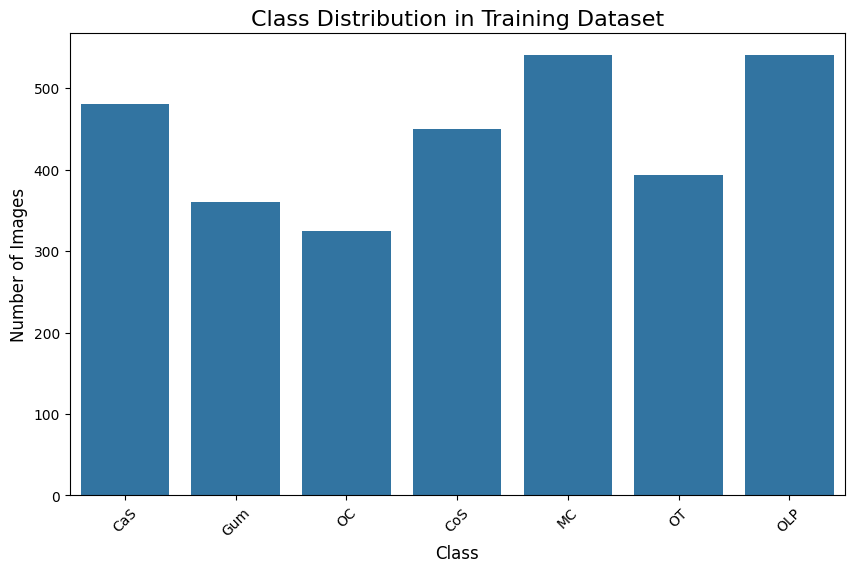

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count class distribution in the training set
def count_classes(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Get class counts
train_class_counts = count_classes(train_path)

# Plot class distribution in Training
plt.figure(figsize=(10, 6))
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()))
plt.title("Class Distribution in Training Dataset", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.show()


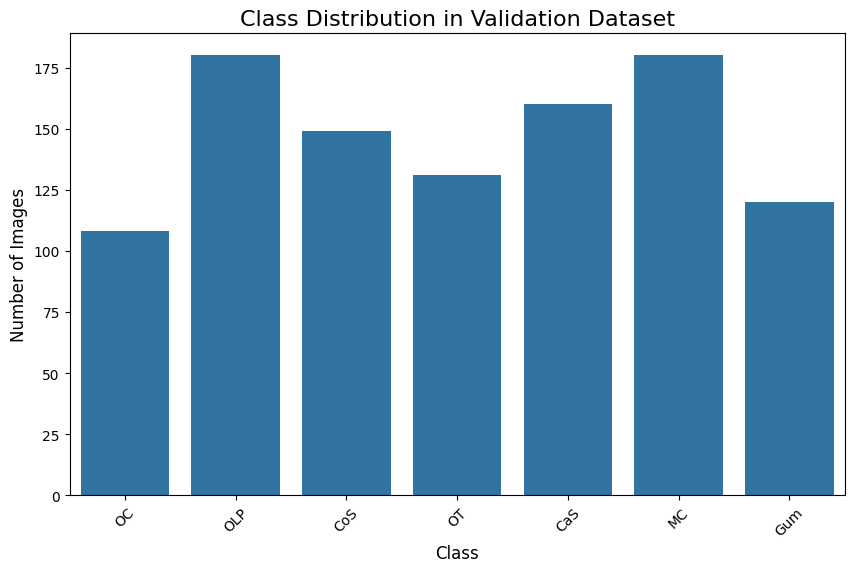

In [ ]:
# Plot class distribution in Validation dataset
val_class_counts = count_classes(val_path)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(val_class_counts.keys()), y=list(val_class_counts.values()))
plt.title("Class Distribution in Validation Dataset", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.show()


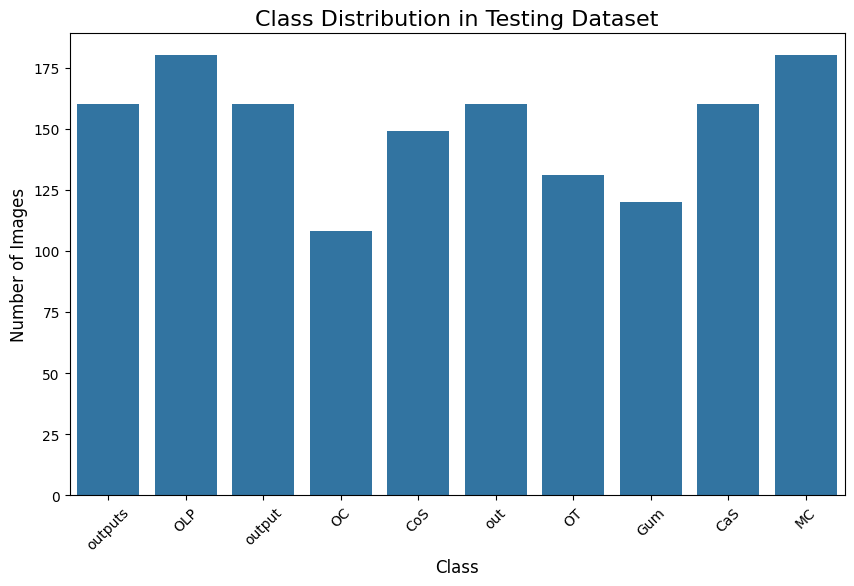

In [ ]:
# Plot class distribution in Testing dataset
test_class_counts = count_classes(test_path)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(test_class_counts.keys()), y=list(test_class_counts.values()))
plt.title("Class Distribution in Testing Dataset", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Update data generators to use EfficientNet preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## Modeling

In [10]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Build the model
batch_size = 32
model = tf.keras.models.Sequential(name="MyModel")
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())  # Move BatchNormalization here
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])


In [12]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


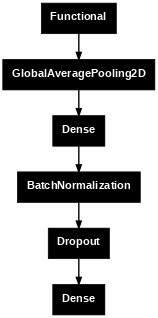

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png' , dpi=50)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=40,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 159s 893ms/step - accuracy: 0.2661 - loss: 6.7423 - precision_2: 0.3037 - recall_2: 0.1952 - val_accuracy: 0.4639 - val_loss: 5.6640 - val_precision_2: 0.7256 - val_recall_2: 0.1162 - learning_rate: 1.0000e-04
Epoch 2/40
 1/96 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.5625 - loss: 5.7564 - precision_2: 0.6154 - recall_2: 0.5000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5625 - loss: 5.7564 - precision_2: 0.6154 - recall_2: 0.5000 - val_accuracy: 0.4688 - val_loss: 5.6527 - val_precision_2: 0.7326 - val_recall_2: 0.1230 - learning_rate: 1.0000e-04
Epoch 3/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 859ms/step - accuracy: 0.5886 - loss: 5.3862 - precision_2: 0.6581 - recall_2: 0.5200 - val_accuracy: 0.7646 - val_loss: 4.8879 - val_precision_2: 0.8706 - val_recall_2: 0.5781 - learning_rate: 1.0000e-04
Epoch 4/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6250 - loss: 4.9914 - precision_2: 0.7037 - recall_2: 0.5938 - val_accuracy: 0.7646 - val_loss: 4.8801 - val_precision_2: 0.8735 - val_recall_2: 0.5869 - learning_rate: 1.0000e-04
Epoch 5/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 529ms/step - accuracy: 0.7153 - loss: 4.8931 - precision_2: 0.7672 - recall_2: 0.6582 - val_accuracy: 0.8887 - val_loss: 4.3624 - val_precision_2: 0.9363 - val_recall_2: 0.8330 - learning_rate: 1.0000e-04
Epoch 6/40
96/96 ━━━━━━━━━━

In [ ]:
model.summary()

Model: "MyModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,055,922 (49.80 MB)

 Trainable params: 4,337,795 (16.55 MB)

 Non-trainable params: 42,535 (166.16 KB)

 Optimizer params: 8,675,592 (33.09 MB)

## Fine-Tuning

In [ ]:
# Fine-Tuning (Unfreeze Some Layers)
base_model.trainable = True  # Unfreeze the base model
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])


In [ ]:
#  Continue Training (Fine-Tuning)
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=15,  # Train for more epochs
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 126s 794ms/step - accuracy: 0.9849 - loss: 2.6394 - precision_3: 0.9886 - recall_3: 0.9832 - val_accuracy: 0.9971 - val_loss: 2.5720 - val_precision_3: 0.9971 - val_recall_3: 0.9961 - learning_rate: 1.0000e-05
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9688 - loss: 2.6749 - precision_3: 0.9688 - recall_3: 0.9688 - val_accuracy: 0.9971 - val_loss: 2.5717 - val_precision_3: 0.9971 - val_recall_3: 0.9961 - learning_rate: 1.0000e-05
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - accuracy: 0.9862 - loss: 2.5998 - precision_3: 0.9880 - recall_3: 0.9830 - val_accuracy: 0.9971 - val_loss: 2.5374 - val_precision_3: 0.9971 - val_recall_3: 0.9961 - learning_rate: 1.0000e-05
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9688 - loss: 2.5595 - precision_3: 1.0000 - recall_3: 0.9688 - val_accuracy: 0.9971 - val_loss: 2.5370 - val_precision_3: 0.9971 - val_recall_3: 0.9961 - learning_rate: 1.0000e-05
Epoch 5/15
96/9

## Evaluation

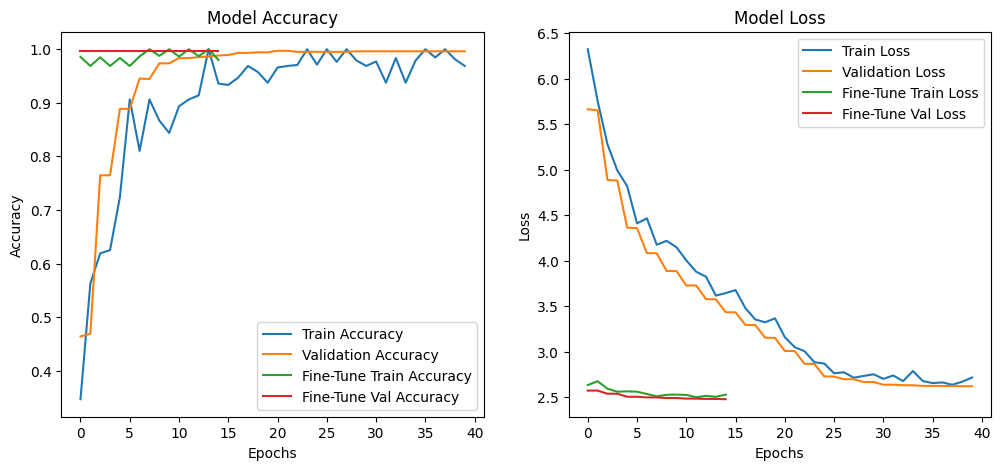

In [ ]:
# Plot Training History
def plot_history(history, history_finetune):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history_finetune.history['accuracy'], label='Fine-Tune Train Accuracy')
    plt.plot(history_finetune.history['val_accuracy'], label='Fine-Tune Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history_finetune.history['loss'], label='Fine-Tune Train Loss')
    plt.plot(history_finetune.history['val_loss'], label='Fine-Tune Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

plot_history(history, history_fine)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 548s 12s/step


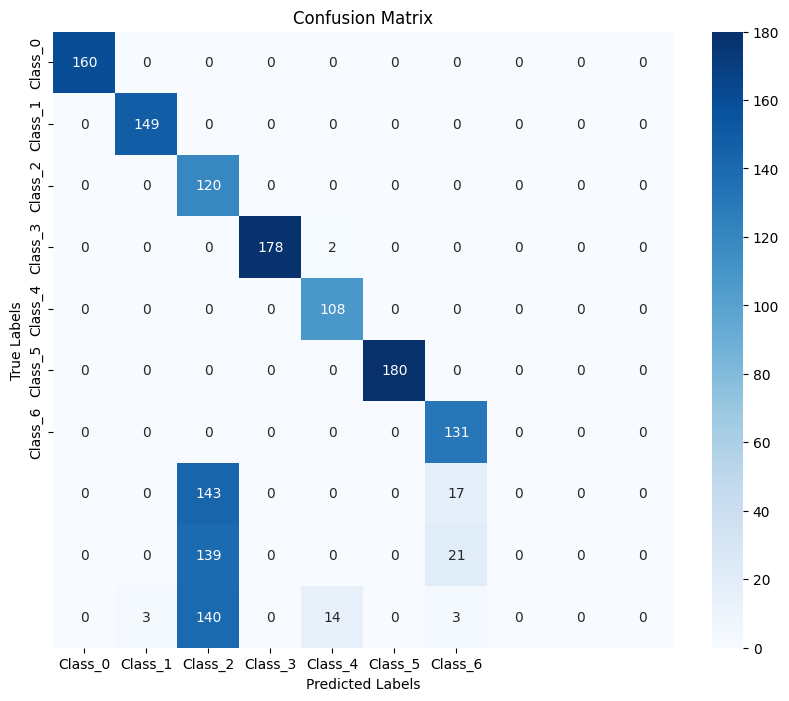

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

#Get true labels from the test generator
y_true = test_generator.classes

# Get predicted labels
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels (replace with your actual class names)
class_labels = ['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model.save('/content/drive/MyDrive/my_model.keras')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
from google.colab import files
files.download('/content/drive/MyDrive/my_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>